# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 2](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

This task aims to categorize the sexist messages according to the intention of the author in one of the following categories: (i) direct sexist message, (ii) reported sexist message and (iii) judgemental message.

### Examples:

#### DIRECT 
The intention was to write a message that is sexist by itself or incites to be sexist, as in:

''*A woman needs love, to fill the fridge, if a man can give this to her in return for her services (housework, cooking, etc), I don’t see what else she needs.*''

#### REPORTED
The intention is to report and share a sexist situation suffered by a woman or women in first or third person, as in:

''*Today, one of my year 1 class pupils could not believe he’d lost a race against a girl.*''

#### JUDGEMENTAL
The intention was to judge, since the tweet describes sexist situations or behaviours with the aim of condemning them.

''*As usual, the woman was the one quitting her job for the family’s welfare…*''

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2025-2026/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.


### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are label for multiple tasks, but we are focusing on **Task 2**.
- For Task 2, label are assigned by six annotators.
- The label for Task 2 represent whether the tweet is non-sexist ('-') or its sexist intention ('DIRECT', 'REPORTED', 'JUDGEMENTAL').







### Example

```
    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "label_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }
```

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as ``pandas.DataFrame``.
3. **Aggregate labels** for Task 2 using majority voting and store them in a new dataframe column called `label`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `label`.
6. **Encode the `label` column**: Use the following mapping

```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

In [1]:
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

In [2]:
path_train = "data/training.json"
df_train = pd.read_json(path_train)
df_train = df_train.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_train.columns = df_train.iloc[0]
df_train = df_train[1:]
df_train.head()
print(f"Loaded {len(df_train)} records from {path_train}")
# df_train.head()

path_test = "data/test.json"
df_test = pd.read_json(path_test)
df_test = df_test.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_test.columns = df_test.iloc[0]
df_test = df_test[1:]
df_test.head()
print(f"Loaded {len(df_test)} records from {path_test}")
# df_test.head()

path_val = "data/validation.json"
df_val = pd.read_json(path_val)
df_val = df_val.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_val.columns = df_val.iloc[0]
df_val = df_val[1:]
df_val.head()
print(f"Loaded {len(df_val)} records from {path_val}")
# df_val.head()

Loaded 6920 records from data/training.json
Loaded 312 records from data/test.json
Loaded 726 records from data/validation.json


In [3]:
df_val.head()

key,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
300001,300001,es,@Fichinescu La comunidad gamer es un antro de ...,6,"[Annotator_726, Annotator_727, Annotator_357, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, NO, YES, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, NO, YES, YES, YES]","[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,300004,es,Also mientras les decia eso la señalaba y deci...,6,"[Annotator_259, Annotator_739, Annotator_291, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,300005,es,"And all people killed, attacked, harassed by ...",6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES


In [4]:
df_test.head()

key,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
400178,400178,en,1st day at the pool on a beautiful Sunday in N...,6,"[Annotator_764, Annotator_765, Annotator_766, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400179,400179,en,“I like your outfit too except when i dress up...,6,"[Annotator_805, Annotator_426, Annotator_806, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, NO]","[JUDGEMENTAL, DIRECT, REPORTED, DIRECT, REPORT...","[[OBJECTIFICATION], [OBJECTIFICATION, MISOGYNY...",DEV_EN
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400181,400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, DIRECT, JUDGEMENTAL, DIRECT, DIRECT, DIRECT]","[[-], [IDEOLOGICAL-INEQUALITY, MISOGYNY-NON-SE...",DEV_EN
400182,400182,en,@ultshunnie u gotta say some shit like “i’ll f...,6,"[Annotator_770, Annotator_771, Annotator_772, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, YES]","[DIRECT, REPORTED, DIRECT, DIRECT, JUDGEMENTAL...","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [SEXUAL-V...",DEV_EN


In [5]:
# Adding the new column 'label'
def most_common_label(labels):

    if ((len(Counter(labels))>1) and (Counter(labels).most_common(1)[0][1] == Counter(labels).most_common(2)[1][1])):
        return pd.NA
    return Counter(labels).most_common(1)[0][0]
    
# Populating the new column with the most common label for each row
df_train['label'] = df_train['labels_task2'].apply(most_common_label)
df_test['label'] = df_test['labels_task2'].apply(most_common_label)
df_val['label'] = df_val['labels_task2'].apply(most_common_label)

# Deleting all the rows with no most common label
df_train_dropna = df_train.dropna(subset=['label'])    
df_test_dropna = df_test.dropna(subset=['label'])    
df_val_dropna = df_val.dropna(subset=['label'])

# Filtering only English tweets and selecting relevant columns
df_train_en = df_train_dropna[df_train_dropna['lang'] == 'en'][['id_EXIST','lang','tweet','label']]
df_test_en = df_test_dropna[df_test_dropna['lang']=='en'][['id_EXIST','lang','tweet','label']]
df_val_en = df_val_dropna[df_val_dropna['lang']=='en'][['id_EXIST','lang','tweet','label']]



In [6]:
df_train_en.head()

key,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,-
200002,200002,en,Writing a uni essay in my local pub with a cof...,REPORTED
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,REPORTED
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,-
200005,200005,en,‘Making yourself a harder target’ basically bo...,-


In [7]:
# Mapping labels to integers
mapping = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}

df_train_en['label'] = df_train_en['label'].map(mapping)
df_test_en['label'] = df_test_en['label'].map(mapping)
df_val_en['label'] = df_val_en['label'].map(mapping)


In [8]:
train_df = df_train_en
val_df = df_val_en
test_df = df_test_en

In [9]:
# Save the processed dataframes for future tasks
train_df.to_csv('processed_train.csv', index=False)
val_df.to_csv('processed_validation.csv', index=False)
test_df.to_csv('processed_test.csv', index=False)


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [10]:
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from spellchecker import SpellChecker

In [11]:
# Task 2 - Data Cleaning
# Download required NLTK data
print("Downloading NLTK resources...")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

train_df = pd.read_csv('processed_train.csv')
val_df = pd.read_csv('processed_validation.csv')
test_df = pd.read_csv('processed_test.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

def clean_tweet(tweet):
    """
    Clean and preprocess a tweet by removing unwanted elements and performing lemmatization
    """
    if pd.isna(tweet):
        return ""
    
    # Convert to string if not already
    tweet = str(tweet)


    # Remove emojis and emoticons
    # First pattern: remove common emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # Misc symbols
                           u"\U000024C2-\U0001F251"  # Enclosed characters 
                           "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)   

    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove special characters and symbols. Keep letters, numbers, and basic punctuation (.!?)
    tweet = re.sub(r'([.!?])', r' \1 ', tweet)
    tweet = re.sub(r'[^\w\s.!?]', ' ', tweet)

    tweet = re.sub(r"(.)\1{2,}", r"\1\1", tweet)

    # Remove specific quote characters
    tweet = re.sub(r'[“”‘’"\']', '', tweet)
    
    # Tokenize and lemmatize
    tokens = word_tokenize(tweet)
    lemmatized_tokens = []
    
    for token in tokens:
        if token.isalpha():
            corrected = spell.correction(token),lower() or token
            # Lemmatize (try noun first,verb, then adjectives)
            lemma = lemmatizer.lemmatize(corrected, pos='n')  # noun
            lemma = lemmatizer.lemmatize(lemma, pos='v')           # verb
            lemma = lemmatizer.lemmatize(lemma, pos='a')          # adjective
            lemmatized_tokens.append(lemma)
        else:
            lemmatized_tokens.append(token)
    
    # Rejoin tokens
    cleaned_tweet = ' '.join(lemmatized_tokens)
    
    # Remove extra whitespace
    cleaned_tweet = re.sub(r'\s+', ' ', cleaned_tweet).strip()
    
    return cleaned_tweet

In [14]:
# Apply cleaning 
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
val_df['tweet'] = val_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

In [ ]:
sample_indices = [0, 5, 10]  # Sample indices to display

for idx in sample_indices:
    if idx < len(train_df):
        
        print(f"Example {idx + 1}:")
        print( train_df.iloc[idx]['tweet'])
        print("-" * 80)

Example 1:
ffs ! how about lay the blame on the bastard who murder her ? novel idea i know .
--------------------------------------------------------------------------------
Example 6:
accord to a customer i have plenty of time to go spend the stirling coin he want to pay me with in derry . just like any other woman im sure of it . in retail .
--------------------------------------------------------------------------------
Example 11:
mean woman usually end up in low pay support work when that start to change traditionalist notice unfairness that previously hasnt bother them at all .
--------------------------------------------------------------------------------


In [ ]:
train_df.to_csv('cleaned_train.csv', index=False)
val_df.to_csv('cleaned_validation.csv', index=False)
test_df.to_csv('cleaned_test.csv', index=False)

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., ``<UNK>``) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [15]:
# Task 3 - Text Encoding with GloVe Embeddings
import numpy as np
from collections import defaultdict
from collections import OrderedDict
import requests
import os
import zipfile
from tqdm import tqdm
import gensim
import gensim.downloader as gloader
from typing import List, Callable, Dict

# Load cleaned datasets
train_df = pd.read_csv('cleaned_train.csv')
val_df = pd.read_csv('cleaned_validation.csv')
test_df = pd.read_csv('cleaned_test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 2873
Validation samples: 150
Test samples: 280


In [16]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [17]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300
embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=50)

In [18]:
def build_vocabulary(
    df: pd.DataFrame
) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build 
    the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    # reserve special tokens
    word_to_idx['<PAD>'] = 0
    idx_to_word[0] = '<PAD>'
    word_to_idx['<UNK>'] = 1
    idx_to_word[1] = '<UNK>'

    
    curr_idx = 2  # start from 2 to reserve 0 for <PAD> and 1 fro <UNK>
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [19]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(train_df)

print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')

some_words = [(idx_to_word[idx], idx) for idx in np.arange(10) ]
print(f'[Debug] Some words: {some_words}')

vocab_size = len(word_to_idx)

100%|██████████| 2873/2873 [00:00<00:00, 203019.72it/s]

[Debug] Index -> Word vocabulary size: 7797
[Debug] Word -> Index vocabulary size: 7797
[Debug] Some words: [('<PAD>', np.int64(0)), ('<UNK>', np.int64(1)), ('ifs', np.int64(2)), ('!', np.int64(3)), ('how', np.int64(4)), ('about', np.int64(5)), ('lay', np.int64(6)), ('the', np.int64(7)), ('blame', np.int64(8)), ('on', np.int64(9))]


### Inspecting OOVs

In [20]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [21]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

oov_sample = oov_terms[:20]
print(f"Some OOV terms: {oov_sample}")

Total OOV terms: 492 (6.31%)
Some OOV terms: ['manspreading', '38original', 'i2m', 'brazilin', 'casiajonna3874', 'filterability', 'zunelhakart', 'itsnotacomplimentmelbourne', 'reallymanchin', 'no_tall_men', 'anddodge', 'nonbinary', 'exoticization', 'farci', 'vlkxxrrrot', 'zhangchengexplicit', 'truefender', 'beclouded', 'duodenary', 'rendelshem']


### Building embedding matrix

In [22]:
'''
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given 
    a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector 
        to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix
'''

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix keeping PAD (idx 0) as all-zeros so mask_zero works.
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    rng = np.random.RandomState(seed=12345)

    # Fill embeddings but do NOT overwrite PAD (idx==0)
    for word, idx in tqdm(word_to_idx.items()):
        if idx == 0:
            # keep PAD as zero vector for mask_zero=True
            continue
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = rng.uniform(low=-0.05, high=0.05, size=embedding_dimension).astype(np.float32)

        embedding_matrix[idx] = embedding_vector

    # Set a stable <UNK> vector (mean of known embeddings) if available
    unk_idx = word_to_idx.get('<UNK>', None)
    if unk_idx is not None and unk_idx != 0:
        # average only non-zero rows (skip PAD)
        non_zero_mask = np.linalg.norm(embedding_matrix, axis=1) > 0
        if non_zero_mask.sum() > 0:
            embedding_matrix[unk_idx] = embedding_matrix[non_zero_mask].mean(axis=0).astype(np.float32)
        else:
            # fallback
            embedding_matrix[unk_idx] = rng.uniform(low=-0.05, high=0.05, size=embedding_dimension).astype(np.float32)

    return embedding_matrix

In [23]:
# Testing
embedding_dimension = 50
embedding_matrix = build_embedding_matrix(embedding_model,
                                          embedding_dimension,
                                          word_to_idx,
                                          vocab_size,
                                          oov_terms)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7797/7797 [00:00<00:00, 379332.21it/s]

Embedding matrix shape: (7797, 50)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* **Stacked**: add an additional Bidirectional LSTM layer to the Baseline model.

**Note**: You are **free** to experiment with hyper-parameters.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape ``(batch_size, # tokens, embedding_dim)`` to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

### Embedding model definition

In [25]:
# I chose the 'embedding layer' option

max_len = 50

embedding = Embedding(input_dim=vocab_size,
                        output_dim=embedding_dimension,
                        weights=[embedding_matrix],
                        input_length=max_len,  # ensures model expects sequences of length max_len
                        mask_zero=True,                   # automatically masks padding tokens
                        trainable = False, # to freeze the embeddings during training
                        name='encoder_embedding')

c:\ProgramData\anaconda3\envs\NLP\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Baseline model definition

In [39]:
# model definition

baseline_model = Sequential([
    # embedding layer
    embedding,
    # Bidirectional LSTM layer
    Bidirectional(LSTM(64, return_sequences=False)),
    # Fully connected (Dense) layer
    Dense((64), activation='relu'),
    Dropout(0.5),
    # Output layer
    Dense(4, activation='softmax')
])

# Use categorical or sparse categorical loss depending on your label encoding
baseline_model.compile(
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if one-hot encoded
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

In [27]:

baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)   │ ?                      │       389,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,850 (1.49 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 389,850 (1.49 MB)

## Stacked model definition

In [ ]:
# model definition

stacked_model = Sequential([
    # embedding layer
    embedding,

    # 1st Bidirectional LSTM layer
    Bidirectional(LSTM(32, return_sequences=True)),
    # 2nd Bidirectional LSTM layer
    Bidirectional(LSTM(32)),
    # Fully connected (Dense) layer
    Dense(32, activation='relu'),
    Dropout(0.5),
    # Output layer
    Dense(4, activation='softmax')
])

# Use categorical or sparse categorical loss depending on your label encoding
stacked_model.compile(
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' if one-hot encoded
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [29]:

#stacked_model.build(input_shape=(None, max_len))
# input_length is the max length of your input sequences (tweet) after tokenization and padding

stacked_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)   │ ?                      │       389,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,850 (1.49 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 389,850 (1.49 MB)

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Stacked models.



### Instructions

* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

In [30]:
random_seed1 = 42
random_seed2 = 1312
random_seed3 = 1234

tf.random.set_seed(random_seed1)

In [31]:
train_df.head()

,id_EXIST,lang,tweet,label
0,200001,en,ifs ! how about lay the blame on the bastard w...,0
1,200002,en,writing a uni essay in my local pub with a cof...,3
2,200003,en,it be 2021 not 1921 . i don t appreciate that ...,3
3,200004,en,this be unacceptable . use her title a you do ...,0
4,200005,en,making yourself a hard target basically boil d...,0


### Preparing train and validation sets

In [32]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def texts_to_padded_sequences(texts, word_to_idx, max_len=None, pad_value=0):
    unk_id = word_to_idx.get('<UNK>', None)
    seqs = []
    for t in texts:
        ids = []
        for tok in str(t).split():
            idx = word_to_idx.get(tok, unk_id)
            if idx is None:
                idx = pad_value
            ids.append(idx)
        seqs.append(ids)
    if max_len is None:
        max_len = max((len(s) for s in seqs), default=0)
    arr = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post', value=pad_value)
    return np.asarray(arr, dtype=np.int32)


# build arrays
X_train = texts_to_padded_sequences(train_df['tweet'].values, word_to_idx)
X_val   = texts_to_padded_sequences(val_df['tweet'].values,   word_to_idx)

y_train = train_df['label'].values.astype(np.int32)
y_val   = val_df['label'].values.astype(np.int32)

In [33]:
# Sanity checks for padding / unknown tokens
pad_idx = word_to_idx.get('<PAD>')
unk_idx = word_to_idx.get('<UNK>')

assert pad_idx is not None, "<PAD> not found in word_to_idx"
assert unk_idx is not None, "<UNK> not found in word_to_idx"
assert pad_idx == 0, f"<PAD> index is {pad_idx}, expected 0"
assert unk_idx == 1, f"<UNK> index is {unk_idx}, expected 1"

print("Embedding matrix shape:", embedding_matrix.shape)
assert embedding_matrix.shape == (vocab_size, embedding_dimension)

# PAD vector in embedding matrix must be all zeros
pad_vec = embedding_matrix[pad_idx]
print("PAD vector norm (embedding_matrix):", np.linalg.norm(pad_vec))
assert np.allclose(pad_vec, 0.0), "PAD vector in embedding_matrix is not all zeros!"

# Check <UNK> vector is not zero (should be distinct)
print("<UNK> vector norm:", np.linalg.norm(embedding_matrix[unk_idx]))

# If you already created the Keras Embedding layer, ensure its weight row 0 is zero
if 'embedding' in globals() and hasattr(embedding, 'get_weights'):
    w = embedding.get_weights()[0]
    print("Embedding layer weights shape:", w.shape)
    if not np.allclose(w[0], 0.0):
        print("-> PAD row in Embedding layer is non-zero. Overwriting to zeros and setting trainable=False.")
        w[0] = np.zeros(embedding_dimension, dtype=np.float32)
        embedding.set_weights([w])
        embedding.trainable = False
    print("PAD vector norm (embedding layer):", np.linalg.norm(embedding.get_weights()[0][0]))

# Quick dataset checks: padding fraction and id ranges
print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)
pad_frac_train = (X_train == pad_idx).sum() / X_train.size
pad_frac_val = (X_val == pad_idx).sum() / X_val.size
print(f"Pad fraction - train: {pad_frac_train:.4f}, val: {pad_frac_val:.4f}")

# Ensure no accidental use of 0 for unknown tokens (unknowns should be mapped to <UNK>=1)
unique_train = np.unique(X_train)
unique_val = np.unique(X_val)
print("Train token id min/max:", unique_train.min(), unique_train.max())
print("Val token id min/max:  ", unique_val.min(), unique_val.max())

# Optional: list a few token ids that appear in val but are not in vocabulary indices range
out_of_range_val = unique_val[(unique_val < 0) | (unique_val >= vocab_size)]
if len(out_of_range_val):
    print("Warning: token ids in val out of vocab range:", out_of_range_val)
else:
    print("All token ids in train/val are within [0, vocab_size).")

Embedding matrix shape: (7797, 50)
PAD vector norm (embedding_matrix): 0.0
<UNK> vector norm: 1.5869364
Embedding layer weights shape: (7797, 50)
PAD vector norm (embedding layer): 0.0
X_train shape: (2873, 71) X_val shape: (150, 61)
Pad fraction - train: 0.5930, val: 0.5136
Train token id min/max: 0 7796
Val token id min/max:   0 7753
All token ids in train/val are within [0, vocab_size).


In [34]:
# Training: add callbacks and class weights
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# compute balanced class weights
cls = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes=cls, y=y_train)
class_weight_dict = {int(k): float(v) for k, v in zip(cls, cw)}

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]


### Plotting function

In [35]:
#plottig function

import matplotlib.pyplot as plt

def plot_train_val_loss(history, label='Model', save_path=None):
    # accept Keras History object or a plain dict
    hist = history.history if hasattr(history, 'history') else history
    loss = hist.get('loss')
    val_loss = hist.get('val_loss')
    if loss is None:
        raise ValueError("history does not contain 'loss' key")
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, loss, 'o-', label=f'{label} train')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 's--', label=f'{label} val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{label} loss')
    plt.grid(True)
    plt.legend()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## Baseline Model Training

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3561 - loss: 1.3079 - val_accuracy: 0.3067 - val_loss: 1.3476 - learning_rate: 1.5625e-05
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3599 - loss: 1.3142 - val_accuracy: 0.3533 - val_loss: 1.3414 - learning_rate: 1.5625e-05
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3564 - loss: 1.3045 - val_accuracy: 0.3800 - val_loss: 1.3357 - learning_rate: 1.5625e-05
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3756 - loss: 1.3144 - val_accuracy: 0.3867 - val_loss: 1.3347 - learning_rate: 7.8125e-06
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3662 - loss: 1.3177 - val_accuracy: 0.4000 - val_loss: 1.3344 - learning_rate: 7.8125e-06
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3763 - loss: 1.3110 - val_accuracy: 0.4200 - val_loss: 1.3301 - learning_rate: 7.8125e-06
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3756 

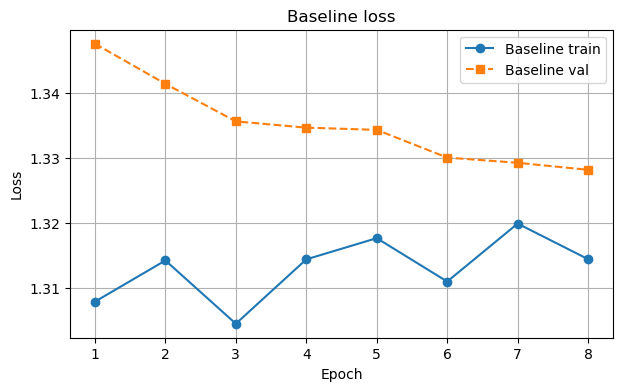

In [45]:
#training the model
bl_history = baseline_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

plot_train_val_loss(bl_history, label='Baseline')

## Stacked Model Training

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4212 - loss: 1.3167 - val_accuracy: 0.3400 - val_loss: 1.3500 - learning_rate: 1.5625e-05
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4100 - loss: 1.3148 - val_accuracy: 0.3400 - val_loss: 1.3494 - learning_rate: 1.5625e-05
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4003 - loss: 1.3169 - val_accuracy: 0.3467 - val_loss: 1.3482 - learning_rate: 1.5625e-05
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3989 - loss: 1.3112 - val_accuracy: 0.3400 - val_loss: 1.3501 - learning_rate: 7.8125e-06
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4006 - loss: 1.3137 - val_accuracy: 0.3267 - val_loss: 1.3492 - learning_rate: 7.8125e-06
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4062 - loss: 1.3148 - val_accuracy: 0.3333 - val_loss: 1.3468 - learning_rate: 7.8125e-06
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3961 

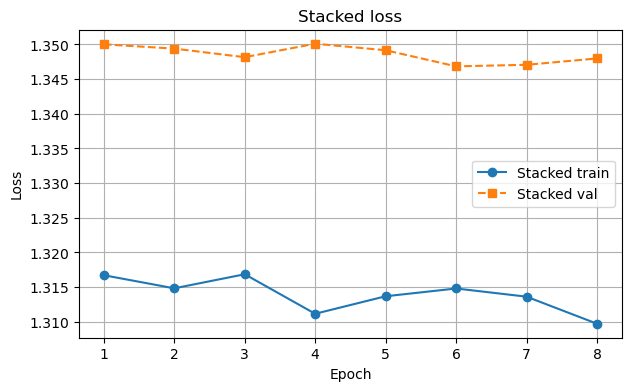

In [46]:
#training the model
st_history = stacked_model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

plot_train_val_loss(st_history, label='Stacked')

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
- **Load the Tokenizer and Model**

- **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

- **Train the Model**:
   Use the `Trainer` to train the model on your training data.

- **Evaluate the Model on the Test Set** using the same metrics used for LSTM-based models.

# [Task 7 - 0.5 points] Error Analysis

After evaluating the model, perform a brief error analysis:

### Instructions

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is **not a copy-paste** of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

## Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions

**Note**: bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Suggestions for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 5 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Expected Results

Task 2 leaderboard reports around 40-50 F1-score.
However, note that they perform a hierarchical classification.

That said, results around 30-40 F1-score are **expected** given the task's complexity.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.


# The End

Feel free to reach out for questions/doubts!